In [1]:
!nvidia-smi

Sun Jul 28 10:06:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'Colab Notebooks'   data   web


# Change Directory

In [3]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data/fcn_pytorch") # to project dir
print(os.getcwd())
!ls

'My Drive'
/content
/content/drive/My Drive/data/fcn_pytorch
checkpoint_fcn8s.tar  fcn8s.onnx  fcn8s.pt  log


# Import

In [0]:
import os
import re
import time
import random
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torch.optim as optim

# Setting Directory

In [0]:
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

train_data_dir = "../datasets/voc_semseg/train"
val_data_dir = "../datasets/voc_semseg/val"

train_img_dir = os.path.join(train_data_dir, 'img')
train_gt_dir = os.path.join(train_data_dir, 'gt')
val_img_dir = os.path.join(val_data_dir, 'img')
val_gt_dir = os.path.join(val_data_dir, 'gt')

# Utility Functions

In [0]:
def key_sort_by_num(x):
    re_list = re.findall(r"[0-9]+", x)
    re_list = list(map(int, re_list))
    return re_list


def list_from_dir(dir, target_ext=None):
    img_list = []
    fnames = os.listdir(dir)
    fnames = sorted(fnames, key=key_sort_by_num)
    for fname in fnames:
        if target_ext is None:
            path = os.path.join(dir, fname)
            img_list.append(path)
        else:
            _, ext = os.path.splitext(fname)
            if ext.lower() in target_ext:
                path = os.path.join(dir, fname)
                img_list.append(path)
    return img_list

In [0]:
#train_data_paths = list_from_dir(train_img_dir, ('.jpg', '.png'))
#train_gt_paths = list_from_dir(train_gt_dir, ('.jpg', '.png'))
#val_data_paths = list_from_dir(val_img_dir, ('.jpg', '.png'))
#val_gt_paths = list_from_dir(val_gt_dir, ('.jpg', '.png'))

#print(len(train_data_paths))
#print(len(train_gt_paths))
#print(len(val_data_paths))
#print(len(val_gt_paths))

In [0]:
def make_cmap():
    """ Make PASCAL VOC color map
    """
    ctbl = ((0x80, 0, 0), (0, 0x80, 0), (0, 0, 0x80),
            (0x40, 0, 0), (0, 0x40, 0), (0, 0, 0x40),
            (0x20, 0, 0), (0, 0x20, 0))

    n = 256
    lookup = np.zeros((n, 3)).astype(np.int32)
    for i in range(0, n):
        r, g, b = 0, 0, 0
        for j in range(0, 7):
            bit = (i >> j) & 1
            if bit:
                r |= ctbl[j][0]
                g |= ctbl[j][1]
                b |= ctbl[j][2]

        lookup[i, 0], lookup[i, 1], lookup[i, 2] = r, g, b
    return lookup[0:21]

In [0]:
def pil_to_tensor(pil_img):
    """ Convert from PIL to tensor
     # Arguments
            pil_img: pil img, 3 dimention(H x W x C)
    """
    img = np.array(pil_img, copy=False)
    img = img.transpose((2, 0, 1)) # H x W x C -> C x H x W
    img = img.astype(np.float32) # uint8 -> float32
    img = torch.from_numpy(img) # ndarray -> tensor
    img.div_(255)
    return img


def tensor_to_pil(tesnor_img):
    """ Convert from Tensor to PIL
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return Image.fromarray(img)


def tensor_to_ndarray(tesnor_img):
    """ Convert from Tensor to ndarray
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return img


def pil_to_one_hot_array(label_array, classes, size):
    """ Convert from PIL to one-hot-array
     # Arguments
            label_array: ndarray, 3 dimention(H x W x C)
            classes: int, num of class
            size: int, image size
    """
    x = np.zeros((classes, size, size)) # C x H x W
    
    for i in range(size):
        for j in range(size):
            x[label_array[i][j], i, j] = 1

    return x


def pred_to_pil(pred):
    """ Convert from one-hot-array to PIL
     # Arguments
            pred: tensor, 3 dimention(C x H x W)
    """
    cmap = make_cmap()
    
    pred_ = pred.numpy() # tensor -> ndarray
    channel, _, _ = pred_.shape
    pred_ = pred_.transpose(1, 2, 0) # C x H x W -> H x W x C
    pred_ = np.argmax(pred_, axis=2) #  H x W x C -> H x W
    
    row, col = pred_.shape
    dst = np.ones((row, col, 3))
    
    for i in range(channel):
        dst[pred_ == i] = cmap[i]

    dst = dst.astype(np.uint8)
    return  Image.fromarray(dst) # ndarray -> PIL

In [0]:
class ResizeAndPadding:
    def __init__(self, size, interpolation=Image.BILINEAR, pad=True):
        self.size = size
        self.interpolation = interpolation
        self.pad = pad

    def __call__(self, img):
        """Resize and Padding
         # Arguments
                img: pil img, 3 dimention(H x W x C)
        """
        size_wh = img.size

        ratio = float(self.size)/max(size_wh)
        new_size_wh = tuple([int(x * ratio) for x in size_wh])

        img = img.resize(new_size_wh, resample=self.interpolation)

        if self.pad:
            mode = img.mode
            new_img = Image.new(mode, (self.size, self.size))
            new_img.paste(img,
                                       ((self.size-new_size_wh[0])//2,
                                         (self.size-new_size_wh[1])//2))
        else:
            new_img = img

        return new_img

    
class RandomCropForSemseg:
    def __init__(self, size):
        self.target_size = size
        
    def __call__(self, img, target=None):
        """Random crop img and label
         # Arguments
                img: pil img, 3 dimention(H x W x C)
                target: label img, 3 dimention(H x W x C)
        """
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.target_size,self.target_size))
        img = TF.crop(img, i, j, h, w)
        if target is not None:
            target = TF.crop(target, i, j, h, w)
            
        return img, target
    
    
class RandomFlipForSemseg:
    def __init__(self):
            pass

    def __call__(self, img, target=None):
        """Random flip img and label
         # Arguments
                img: pil img, 3 dimention(H x W x C)
                target: label img, 3 dimention(H x W x C)
        """
        if random.random() < 0.5:
            img = TF.hflip(img)
            if target is not None:
                target = TF.hflip(target)

        return img, target

In [0]:
def show_imgs(imgs, size,  figsize=[6.4, 4.8], converter=False):
    """Show images
     # Arguments
            imgs: 1-D array, 4 dimention(batch x H x W x C)
            row: Int, row for plt.subplot
            col: Int, column for plt.subplot
    """
    row, col = size
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

  
    plt.figure(figsize=figsize)
    plt.tight_layout()

    for i, img in enumerate(imgs):
        if converter:
            img = converter(img)
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Create Dataset and DataLoader

In [0]:
class SemSegDataset(Dataset):
    
    def __init__(self, classes, input_size, img_dir, target_dir=None, train=False):
        self.classes = classes
        self.input_size = input_size
        self.img_paths, self.target_paths = self._get_paths(img_dir, target_dir)
        self.train = train
     
        #-------------------------------------------
        # transforms
        #-------------------------------------------
        self.trans_resize_and_pad = ResizeAndPadding(self.input_size)
        self.train_trans_crop = RandomCropForSemseg(self.input_size)
        self.train_trans_flip = RandomFlipForSemseg()
        self.eval_trns = transforms.Compose([
            transforms.CenterCrop(self.input_size)
        ])

        #-------------------------------------------
        # check data num
        #-------------------------------------------
        img_num = len(self.img_paths)
        if target_dir:
            target_num = len(self.target_paths)
            assert img_num == target_num, "img/gt not equal, img:{} gt:{}".format(img_num, target_num)
        
        self.data_num = img_num

        
    def __len__(self):
        return self.data_num
    
    
    def _get_paths(self, img_dir, target_dir):
        img_paths = list_from_dir(img_dir, ('.jpg', '.png'))
        if target_dir:
            target_paths = list_from_dir(target_dir, ('.jpg', '.png'))
        else:
            target_paths = None
            
        return img_paths, target_paths
    
    
    def _transform(self, img, target, train):
        
        #-------------------------------------------
        # Padding and Resize if needed
        #-------------------------------------------
        if min(img.size) < self.input_size:            
            img = self.trans_resize_and_pad(img)
            if target:
                target = self.trans_resize_and_pad(target)

        
        if train:
            #-------------------------------------------
            # Random Crop
            #-------------------------------------------
            img, target = self.train_trans_crop(img, target)
      
            #-------------------------------------------
            # Random Flip
            #-------------------------------------------
            img, target = self.train_trans_flip(img, target)
    
        else:
            #-------------------------------------------
            # Evaluation
            #-------------------------------------------
            img = self.eval_trns(img)
            if target:
                target = self.eval_trns(target)
     
        img = pil_to_tensor(img) # 0-255 -> 0-1
        
        if target:
            target = np.asarray(target, dtype=np.int32)
            target[target == 255] = 0  # 境界部分をbackgroundクラスにする

            target = pil_to_one_hot_array(target, self.classes, self.input_size)
            target = torch.from_numpy(target).long() # ラベルをtensor型に変換
        
        return img, target

    def __getitem__(self, idx):
        assert idx < self.data_num,"invalid idx {}, max idx is {}".format(idx, self.data_num-1)
        
        img = Image.open(self.img_paths[idx])
        if self.target_paths:
            target = Image.open(self.target_paths[idx])
        else:
            target = None
        
        x, y = self._transform(img, target, self.train)

        return x, y

In [0]:
train_dataset = SemSegDataset(21, 224, train_img_dir, train_gt_dir, train=True)
val_dataset    = SemSegDataset(21, 224, val_img_dir, val_gt_dir, train=False)

In [0]:
x,y = train_dataset[0]

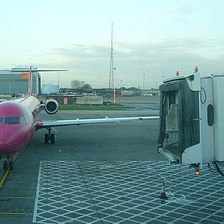

In [19]:
tensor_to_pil(x)

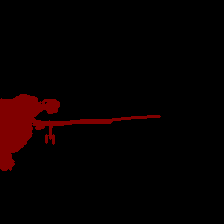

In [20]:
pred_to_pil(y)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
val_dataloader    = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=4)

torch.Size([24, 3, 224, 224])
torch.Size([24, 21, 224, 224])


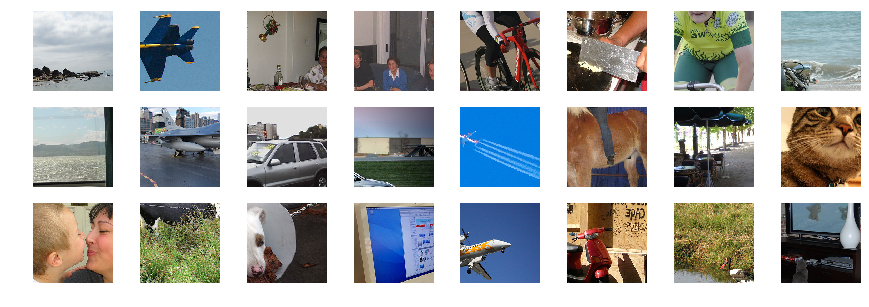

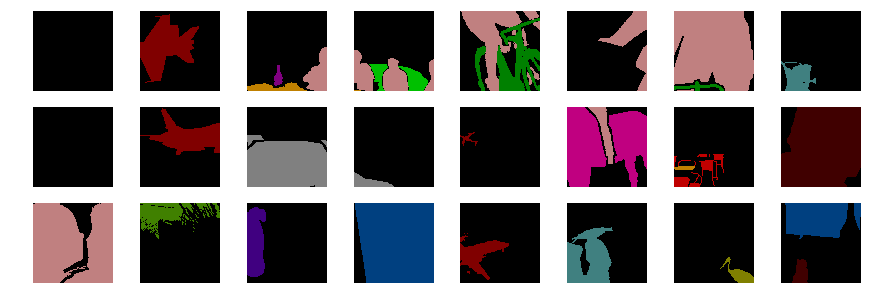

In [22]:
for d in train_dataloader:
    print(d[0].shape)
    print(d[1].shape)
    break
    
            
show_imgs(d[0], [3, 8], figsize=(15,5), converter=tensor_to_ndarray)
show_imgs(d[1], [3, 8], figsize=(15,5), converter=pred_to_pil)

# Define Model

In [0]:
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/models/fcn32s.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """
    Make a 2D bilinear kernel suitable for upsampling
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt

    return torch.from_numpy(weight).float()

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock

class EncorderResNet(ResNet):
    
    def __init__(self, layers=[2, 2, 2, 2]):
        super().__init__(BasicBlock, layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x1 = x # 1/2
        
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x2 = x # 1/4
        x = self.layer2(x)
        x3 = x # 1/8
        x = self.layer3(x)
        x4 = x # 1/16
        x = self.layer4(x)
        x5 = x # 1/32
        
        return x1, x2, x3, x4, x5

In [0]:
class Conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.down_conv(x)
        return x

    
class Downsampling(nn.Module):
    def __init__(self):
        super().__init__()        
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.down(x)
        return x

    
class Upsampling(nn.Module):
    def __init__(self, in_ch, out_ch, batchnorm=False, bilinear=False):
        super().__init__()
        
        self.bilinear = bilinear
        self.batchnorm = batchnorm
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)        
        self.batchnorm = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        if self.bilinear:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        else:
            x = self.up(x)
            if self.batchnorm:
                x = self.batchnorm(x)
            
        return x   

In [0]:
class ResUNet(nn.Module):
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
       
        self.up1 = Upsampling(512, 256, batchnorm=True)
        self.conv6 = Conv(512, 256)
        self.up2 = Upsampling(256, 128, batchnorm=True)
        self.conv7 = Conv(256, 128)
        self.up3 = Upsampling(128, 64, batchnorm=True)
        self.conv8 = Conv(128, 64)
        
        self.up4 = Upsampling(64, 32, batchnorm=True)
        self.conv9 = Conv(64, 32)
        self.conv_skip = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        
        self.conv10 = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0)

        self.up_final = Upsampling(num_classes, num_classes)
        init_w = get_upsampling_weight(num_classes, num_classes, self.up_final.up.kernel_size[0])
        self.up_final.up.weight.data.copy_(init_w)

    
    def forward(self, x):
        
        x1, x2, x3, x4, x5 = self.encorder(x)
        
        x6 = torch.cat([x4, self.up1(x5)], dim=1) # 1/32 -> 1/16
        x6 = self.conv6(x6)
        x7 = torch.cat([x3, self.up2(x6)], dim=1) # 1/16 -> 1/8
        x7 = self.conv7(x7)
        x8 = torch.cat([x2, self.up3(x7)], dim=1) # 1/8 -> 1/4
        x8 = self.conv8(x8)
        
        x1 = self.conv_skip(x1) # ch=64 -> ch=32
        x9 = torch.cat([x1, self.up4(x8)], dim=1) # 1/4 -> 1/2
        x9 = self.conv9(x9)
        
        x10 = self.conv10(x9)
        
        x11 = self.up_final(x10) # 1/2 -> 1/1
        
        return x11

In [0]:
def build_resunet(num_classes):
    encorder = build_encorder_resnet18()
    model = ResUNet(21,encorder)
    return model

In [0]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = Conv(3, 64)
        self.conv2 = Conv(64, 128)
        self.conv3 = Conv(128, 256)
        self.conv4 = Conv(256, 512)  
        self.down = Downsampling()
            
        self.conv5 = Conv(512, 1024)
        
        self.up1 = Upsampling(1024, 512)
        self.conv6 = Conv(1024, 512)
        self.up2 = Upsampling(512, 256)
        self.conv7 = Conv(512, 256)
        self.up3 = Upsampling(256, 128)
        self.conv8 = Conv(256, 128)
        self.up4 = Upsampling(128, 64)
        self.conv9 = Conv(128, 64)
        
        self.conv10 = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding=0)
    
    def forward(self, x):
        
        x1 = self.conv1(x)
        x2 = self.conv2(self.down(x1))
        x3 = self.conv3(self.down(x2))     
        x4 = self.conv4(self.down(x3))

        x5 = self.conv5 (self.down(x4))
        
        x6 = torch.cat([x4, self.up1(x5)], dim=1)
        x6 = self.conv6(x6)
        x7 = torch.cat([x3, self.up2(x6)], dim=1)
        x7 = self.conv7(x7)
        x8 = torch.cat([x2, self.up3(x7)], dim=1)
        x8 = self.conv8(x8)
        x9 = torch.cat([x1, self.up4(x8)], dim=1)
        x9 = self.conv9(x9)
        
        x10 = self.conv10(x9)
        
        return x10

In [0]:
from torchvision import models
def build_encorder_resnet18():
    encorder = EncorderResNet(layers=[2, 2, 2, 2])
    encorder.load_state_dict(models.resnet18(pretrained=True).state_dict())
    return encorder

# Create Model

In [31]:
# model = UNet(num_classes=21)
model = build_resunet(21)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 148113935.84it/s]


In [32]:
from torchsummary import summary
summary(model,  input_size=(3, 224, 224),   device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Define Trainer

In [33]:
# pip install tqdm
pip install fastprogress

In [0]:
# from tqdm import tqdm_notebook as tqdm
from fastprogress import master_bar, progress_bar
import copy
import time


def calc_acc(preds, labels):
    correct = (preds == labels).sum()
    total     = (labels == labels).sum()
    correct = correct.to(torch.float32)
    total     = total.to(torch.float32)
    return (correct / total)


class Trainer:
    
    def __init__(self, model, device, optimizer, criterion, train_loader, val_loader=None,
                          scheduler=None, history=None, prev_epochs=0):

        self.print_state = True
        
        self.done_epochs = prev_epochs # 0-
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.scheduler = scheduler
        
        self.best_val_acc = 0.0
        self.best_model_wts = copy.deepcopy(model.state_dict())
        
        if history:
            self.history = history
        else:
            self.history = {'epoch':[], 'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}
        
        self.train_loader = train_loader
        self.train_data_num = len(self.train_loader.dataset)
        self.train_sptes_per_epoch = len(self.train_loader)
        
        self.val_loader = val_loader
        if self.val_loader:
            self.val_data_num = len(self.val_loader.dataset)
            self.val_sptes_per_epoch = len(self.val_loader)
        else:
            self.val_data_num = 0
            self.val_sptes_per_epoch = 0

        self.model.to(self.device)
        
        
    def set_print_state(self, state=True):
        self.print_state = state
        
        
    def train_loop(self, epochs):
        total_epochs = self.done_epochs + epochs

        #------------------------------------------------------------------------
        # pre print
        #------------------------------------------------------------------------        
        if self.print_state:
            print("Device :  ", self.device)
            print("Train on {} samples, validate on {} samples".format(self.train_data_num,
                                                                                                                 self.val_data_num))
            for i in range(self.done_epochs):
                done_history_idx = i
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))

        #------------------------------------------------------------------------
        # training loop
        #------------------------------------------------------------------------
        for _ in range(epochs):
            self.history['epoch'].append(self.done_epochs+1) # 1-
            
            start_time = time.time()            
            train_score = self._train_one_epoch()
            end_time = time.time()
            
            self.history['train_acc'].append(train_score['acc'])
            self.history['train_loss'].append(train_score['loss'])
            
            if self.val_loader:
                val_score = self._val_one_epoch()
                self.history['val_acc'].append(val_score['acc'])
                self.history['val_loss'].append(val_score['loss'])
                
                if self.best_val_acc < val_score['acc']:
                    self.best_val_acc = val_score['acc']
                    self.best_model_wts = copy.deepcopy(self.model.state_dict())
                
                if self.scheduler:
                    self.scheduler.step(val_score['loss'])
                    
            else:
                if self.scheduler:
                    self.scheduler.step(train_score['loss'])
                

            self.done_epochs += 1

            #------------------------------------------------------------------------
            # post print
            #------------------------------------------------------------------------
            if self.print_state:
                elapsed_time = end_time-start_time
                done_history_idx = self.done_epochs-1
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))

                    
    def _one_step(self, data, labels, train=True):
            if train:
                self.optimizer.zero_grad()
            
            outputs = self.model(data)
            
            # (batchsize x C x H x W) -> (bachsize x H x W)
            labels = torch.argmax(labels, dim=1, keepdim=False)
            preds = torch.argmax(outputs, dim=1, keepdim=False)
            
            loss = self.criterion(outputs, labels)
            
            if train:
                loss.backward()
                self.optimizer.step()
            
            correct = calc_acc(preds, labels)

            return loss.item(), correct.item()

        
    def _train_one_epoch(self):
        self.model.train()
        
        running_loss = 0
        running_correct = 0

        #for batch_idx, (data, labels) in enumerate(self.train_loader):
        #for batch_idx, (data, labels) in tqdm(enumerate(self.train_loader)):
        for batch_idx, (data, labels) in enumerate(progress_bar(self.train_loader)): # naka
            data, labels = data.to(self.device), labels.to(self.device)
            
            loss, correct = self._one_step(data, labels, train=True)
    
            running_loss       += loss
            running_correct += correct

        train_loss = running_loss      / self.train_sptes_per_epoch
        train_acc = running_correct / self.train_sptes_per_epoch
        
        return {'loss':train_loss, 'acc':train_acc}

    
    def _val_one_epoch(self):
        self.model.eval()
        
        running_loss = 0
        running_correct = 0

        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                
                loss, correct = self._one_step(data, labels, train=False)

                running_loss       += loss
                running_correct += correct
                
        val_loss = running_loss      / self.val_sptes_per_epoch
        val_acc = running_correct / self.val_sptes_per_epoch

        return {'loss':val_loss, 'acc':val_acc}

    
    def save_best_model(self, path):
        torch.save(self.best_model_wts, path)
    

    def save_checkpoint(self, path):
        ckpt = {
            'model_satate_dict':self.model.state_dict(),
            'optimizer_state_dict':self.optimizer.state_dict(),
            'history':self.history
        }
        torch.save(ckpt, path)

# Start Training

In [35]:
criterion = nn.CrossEntropyLoss() # nn.LogSoftmax() + nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                                                                            patience=6,  verbose=True) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
trainer = Trainer(model, device, optimizer, criterion, train_dataloader, val_dataloader,scheduler=exp_lr_scheduler)

cuda:0


In [36]:
trainer.train_loop(60)

Device :   cuda:0
Train on 1464 samples, validate on 1449 samples


Epoch:1/60 train_acc:0.5026% train_loss:2.2264 val_acc:0.6052% val_loss:1.6537 time:132.737


Epoch:2/60 train_acc:0.6860% train_loss:1.3122 val_acc:0.6692% val_loss:1.2909 time:55.102


Epoch:3/60 train_acc:0.7150% train_loss:1.1356 val_acc:0.6818% val_loss:1.1756 time:54.694


Epoch:4/60 train_acc:0.7338% train_loss:1.0431 val_acc:0.6993% val_loss:1.1454 time:54.154


Epoch:5/60 train_acc:0.7405% train_loss:0.9782 val_acc:0.6773% val_loss:1.1997 time:53.572


Epoch:6/60 train_acc:0.7439% train_loss:0.9531 val_acc:0.7057% val_loss:1.0749 time:53.644


Epoch:7/60 train_acc:0.7486% train_loss:0.9069 val_acc:0.7066% val_loss:1.0276 time:53.433


Epoch:8/60 train_acc:0.7543% train_loss:0.8760 val_acc:0.7128% val_loss:1.0158 time:52.609


Epoch:9/60 train_acc:0.7643% train_loss:0.8499 val_acc:0.7461% val_loss:0.9142 time:53.132


Epoch:10/60 train_acc:0.7651% train_loss:0.8340 val_acc:0.7341% val_loss:0.9449 time:52.944


Epoch:11/60 train_acc:0.7813% train_loss:0.7648 val_acc:0.7484% val_loss:0.8845 time:53.052


Epoch:12/60 train_acc:0.7925% train_loss:0.7376 val_acc:0.7425% val_loss:0.9108 time:52.716


Epoch:13/60 train_acc:0.7897% train_loss:0.7421 val_acc:0.7541% val_loss:0.8930 time:52.824


Epoch:14/60 train_acc:0.8008% train_loss:0.7041 val_acc:0.7670% val_loss:0.8429 time:52.944


Epoch:15/60 train_acc:0.8059% train_loss:0.6805 val_acc:0.7613% val_loss:0.8843 time:54.404


Epoch:16/60 train_acc:0.8043% train_loss:0.6897 val_acc:0.7562% val_loss:0.9020 time:54.179


Epoch:17/60 train_acc:0.8157% train_loss:0.6531 val_acc:0.7628% val_loss:0.8702 time:54.166


Epoch:18/60 train_acc:0.8275% train_loss:0.6028 val_acc:0.7655% val_loss:0.8483 time:54.833


Epoch:19/60 train_acc:0.8322% train_loss:0.5864 val_acc:0.7779% val_loss:0.8129 time:54.754


Epoch:20/60 train_acc:0.8340% train_loss:0.5758 val_acc:0.7714% val_loss:0.8300 time:54.307


Epoch:21/60 train_acc:0.8379% train_loss:0.5616 val_acc:0.7949% val_loss:0.7496 time:54.781


Epoch:22/60 train_acc:0.8469% train_loss:0.5385 val_acc:0.7844% val_loss:0.7871 time:55.029


Epoch:23/60 train_acc:0.8520% train_loss:0.5272 val_acc:0.8013% val_loss:0.7278 time:55.366


Epoch:24/60 train_acc:0.8588% train_loss:0.4885 val_acc:0.7910% val_loss:0.7501 time:55.643


Epoch:25/60 train_acc:0.8657% train_loss:0.4645 val_acc:0.7924% val_loss:0.7670 time:56.651


Epoch:26/60 train_acc:0.8643% train_loss:0.4765 val_acc:0.8002% val_loss:0.7347 time:56.710


Epoch:27/60 train_acc:0.8730% train_loss:0.4419 val_acc:0.7934% val_loss:0.7759 time:56.961


Epoch:28/60 train_acc:0.8700% train_loss:0.4463 val_acc:0.8022% val_loss:0.7264 time:56.116


Epoch:29/60 train_acc:0.8766% train_loss:0.4266 val_acc:0.7897% val_loss:0.7381 time:55.793


Epoch:30/60 train_acc:0.8699% train_loss:0.4492 val_acc:0.7940% val_loss:0.7952 time:55.534


Epoch:31/60 train_acc:0.8786% train_loss:0.4156 val_acc:0.7977% val_loss:0.7550 time:54.819


Epoch:32/60 train_acc:0.8835% train_loss:0.3985 val_acc:0.7995% val_loss:0.7577 time:54.952


Epoch:33/60 train_acc:0.8864% train_loss:0.3964 val_acc:0.8031% val_loss:0.7191 time:55.758


Epoch:34/60 train_acc:0.8825% train_loss:0.4071 val_acc:0.7993% val_loss:0.7341 time:55.200


Epoch:35/60 train_acc:0.8848% train_loss:0.3918 val_acc:0.8053% val_loss:0.7220 time:55.463


Epoch:36/60 train_acc:0.8882% train_loss:0.3828 val_acc:0.8134% val_loss:0.6874 time:55.376


Epoch:37/60 train_acc:0.8935% train_loss:0.3663 val_acc:0.8007% val_loss:0.7479 time:54.839


Epoch:38/60 train_acc:0.8939% train_loss:0.3671 val_acc:0.8021% val_loss:0.7338 time:54.995


Epoch:39/60 train_acc:0.8962% train_loss:0.3559 val_acc:0.8066% val_loss:0.7178 time:54.825


Epoch:40/60 train_acc:0.9059% train_loss:0.3210 val_acc:0.8093% val_loss:0.7387 time:55.158


Epoch:41/60 train_acc:0.9018% train_loss:0.3303 val_acc:0.7964% val_loss:0.8054 time:55.046


Epoch:42/60 train_acc:0.9007% train_loss:0.3340 val_acc:0.7919% val_loss:0.7908 time:55.078


Epoch    42: reducing learning rate of group 0 to 1.0000e-03.
Epoch:43/60 train_acc:0.9057% train_loss:0.3251 val_acc:0.8033% val_loss:0.7507 time:55.456


Epoch:44/60 train_acc:0.9115% train_loss:0.3002 val_acc:0.8261% val_loss:0.6507 time:55.175


Epoch:45/60 train_acc:0.9208% train_loss:0.2650 val_acc:0.8287% val_loss:0.6453 time:55.157


Epoch:46/60 train_acc:0.9219% train_loss:0.2679 val_acc:0.8299% val_loss:0.6274 time:55.070


Epoch:47/60 train_acc:0.9228% train_loss:0.2602 val_acc:0.8303% val_loss:0.6283 time:54.605


Epoch:48/60 train_acc:0.9241% train_loss:0.2547 val_acc:0.8314% val_loss:0.6245 time:55.126


Epoch:49/60 train_acc:0.9241% train_loss:0.2557 val_acc:0.8316% val_loss:0.6318 time:55.807


Epoch:50/60 train_acc:0.9302% train_loss:0.2368 val_acc:0.8307% val_loss:0.6422 time:54.535


Epoch:51/60 train_acc:0.9258% train_loss:0.2500 val_acc:0.8332% val_loss:0.6206 time:55.368


Epoch:52/60 train_acc:0.9247% train_loss:0.2523 val_acc:0.8324% val_loss:0.6228 time:55.640


Epoch:53/60 train_acc:0.9294% train_loss:0.2358 val_acc:0.8338% val_loss:0.6219 time:55.438


Epoch:54/60 train_acc:0.9241% train_loss:0.2555 val_acc:0.8339% val_loss:0.6270 time:55.936


Epoch:55/60 train_acc:0.9281% train_loss:0.2415 val_acc:0.8353% val_loss:0.6119 time:55.509


Epoch:56/60 train_acc:0.9304% train_loss:0.2360 val_acc:0.8355% val_loss:0.6143 time:54.936


Epoch:57/60 train_acc:0.9308% train_loss:0.2358 val_acc:0.8362% val_loss:0.6182 time:53.703


Epoch:58/60 train_acc:0.9314% train_loss:0.2308 val_acc:0.8354% val_loss:0.6149 time:53.390


Epoch:59/60 train_acc:0.9316% train_loss:0.2318 val_acc:0.8341% val_loss:0.6333 time:55.125


Epoch:60/60 train_acc:0.9318% train_loss:0.2294 val_acc:0.8349% val_loss:0.6267 time:54.308


In [0]:
trainer.save_checkpoint('checkpoint_fcn8s.tar')
trainer.save_best_model('fcn8s.pt')

# Plot acc and loss curve

In [0]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

### ResUNet

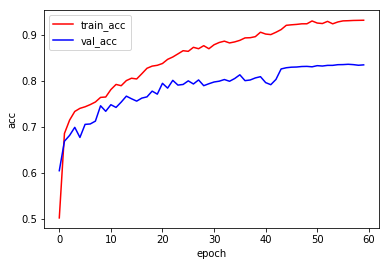

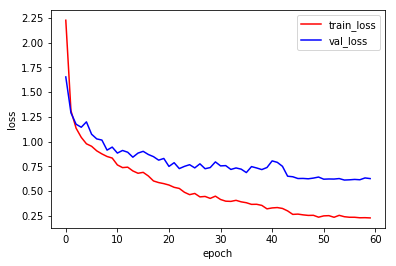

In [38]:
plot_history(trainer.history)

# Evaluate

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('fcn8s.pt', map_location=device))

In [0]:
 classnames=[
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boad",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motor_bike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv"]

In [0]:
def evaluate(model, device, criterion, test_loader):
    model.eval()
    runnning_loss = 0
    running_correct = 0
    with torch.no_grad():
        for data in progress_bar(test_loader):
            imgs, labels = data            
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            labels = torch.argmax(labels, dim=1, keepdim=False)
            pred = torch.argmax(outputs, dim=1, keepdim=False)
            runnning_loss += criterion(outputs, labels).item()
            running_correct += calc_acc(pred, labels)
            
    test_acc = running_correct / len(test_loader)
    test_loss = runnning_loss / len(test_loader)

    return {'loss':test_loss, 'acc':test_acc}

In [42]:
test_loader = val_dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

model = model.to(device)
test_score = evaluate(model, device, criterion, test_loader)

device: cuda


In [43]:
print('acc  : {:.4f}'.format(test_score['acc']))
print('loss : {:.4f}'.format(test_score['loss']) )

acc  : 0.7820
loss : 0.7718


# Predict

In [0]:
def predict(model, device, imgs):
    model.eval()
    
    if len(imgs.size()) != 4:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device)
    
    with torch.no_grad():
        output = model(imgs)
        
    return output

In [0]:
device = 'cpu'
img, label = val_dataset[11]
model.to(device)
out = predict(model, device, img)

label_pil = pred_to_pil(label)
out_pil = pred_to_pil(out[0])
input_pil = tensor_to_pil(img)

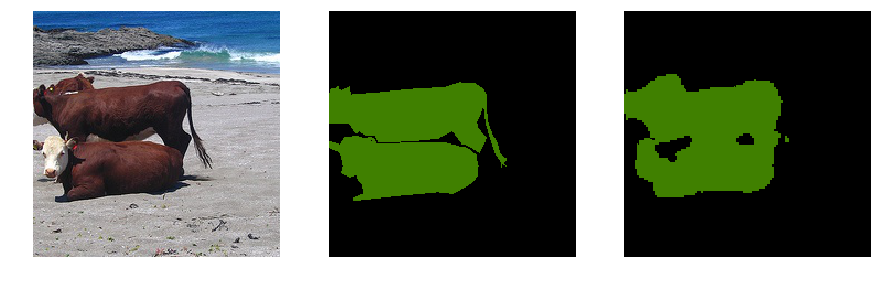

In [46]:
show_imgs([input_pil, label_pil, out_pil], [1, 3], figsize=(15,5))

# Save as ONNX

In [0]:
# pip install torchvision==0.2.1
import torch
dummy_input = torch.randn(1, 3, 224, 224,)
torch_out = torch.onnx.export(model, dummy_input, "fcn8s.onnx", verbose=True)